In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence

In [23]:
DATA_PATH = "./Emotion_classify_Data.csv"

PLOT_COLORS = ["red", "green", "blue"]

EMBEDDING_DIMENSIONS = 100

EPOCHS = 100
BATCH_SIZE = 32

In [24]:
def load_data() -> pd.DataFrame:
    return pd.read_csv(DATA_PATH)

def get_vocabulary(column_with_docs: str, dataframe: pd.DataFrame) -> set:
    documents: list[str] = dataframe[column_with_docs].to_list()
    documents_text: str = " ".join(documents)
    vocabulary: set = set(documents_text.split(" "))
    return vocabulary

def convert_word_to_index(vocabulary: set) -> dict:
    word2indx = {word: index for index, word in enumerate(vocabulary)}
    return word2indx

def create_features_table(unique_values: list) -> dict:
    features_table: dict = {}
    feature_code: int = 0
    for unique_value in unique_values:
        features_table[unique_value] = feature_code
        feature_code += 1
    return features_table

def encode_classes(feature_table: dict, dataframe: pd.DataFrame) -> pd.DataFrame:
    new_df: pd.DataFrame = dataframe.copy()
    
    for k, v in feature_table.items():
        new_df["Emotion"][new_df["Emotion"] == k] = v
    
    return new_df

def vectorize_sentence(word2indx: dict, sentence: str) -> list[int]:
    sentence = sentence.lower().split(" ")
    vector = [word2indx[word] for word in sentence]
    return vector

def convert_to_embedding(emb_layer: nn.Embedding, vector: list[int]) -> torch.LongTensor:
    return emb_layer(torch.LongTensor(vector))

def plot_emotions_distribution(loaded_dataframe: pd.DataFrame):
    emotions = loaded_dataframe["Emotion"].unique()
    emotions_count = []
    for emotion in emotions:
        emotion_doc_counter = len(loaded_dataframe[loaded_dataframe["Emotion"] == emotion])
        emotions_count.append(emotion_doc_counter)
    
    _, ax = plt.subplots()
    ax.bar(emotions, emotions_count, label=emotions, color=PLOT_COLORS)
    ax.set_title("Emotions distribution")
    plt.show()
    

In [25]:
emotion_data = load_data()

In [26]:
emotion_data.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear
3,ive been really angry with r and i feel like a...,joy
4,i feel suspicious if there is no one outside l...,fear


In [27]:
emotion_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


In [28]:
emotion_data.isna().sum()

Comment    0
Emotion    0
dtype: int64

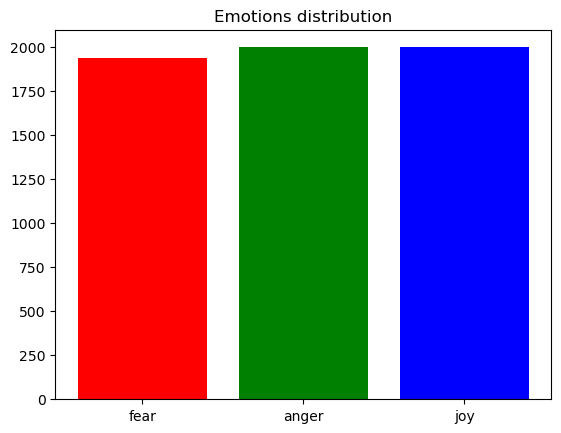

In [29]:
plot_emotions_distribution(emotion_data)

In [30]:
emotion_types = emotion_data["Emotion"].unique()
emotion_types_len = len(emotion_types)
emotion_types_encoding = create_features_table(emotion_types.tolist())
emotion_types, emotion_types_encoding

(array(['fear', 'anger', 'joy'], dtype=object),
 {'fear': 0, 'anger': 1, 'joy': 2})

In [31]:
vocabulary = get_vocabulary("Comment", emotion_data)

In [32]:
vocabulary_size = len(vocabulary)
vocabulary, vocabulary_size

({'suspected',
  'utter',
  'night',
  'movements',
  'blank',
  'sleeves',
  'postponing',
  'term',
  'ambulatory',
  'antics',
  'rant',
  'careeeeee',
  'trimmings',
  'sucker',
  'emoticons',
  'furstenberg',
  'crake',
  'extent',
  'magnitude',
  'hanbeon',
  'wars',
  'scope',
  'soapbox',
  'winter',
  'tighter',
  'prupose',
  'minibus',
  'sale',
  'niga',
  'mundane',
  'permalink',
  'phase',
  'refers',
  'reaction',
  'predictable',
  'xxx',
  'heres',
  'div',
  'dismayed',
  'aac',
  'dunham',
  'capacities',
  'enemies',
  'laze',
  'profoundly',
  'springer',
  'slowly',
  'soley',
  'pit',
  'rapidly',
  'necessarily',
  'undo',
  'weighed',
  'cigarette',
  'anguish',
  'manageable',
  'candy',
  'melancholy',
  'rest',
  'enormously',
  'soup',
  'chocolate',
  'serves',
  'obligated',
  'nick',
  'care',
  'consulted',
  'south',
  'flawless',
  'accepted',
  'cringe',
  'coo',
  'placed',
  'learnt',
  'noisy',
  'most',
  'paparazzi',
  'sees',
  'alba',
  'her

In [33]:
word2indx = convert_word_to_index(vocabulary)

In [34]:
word2indx

{'suspected': 0,
 'utter': 1,
 'night': 2,
 'movements': 3,
 'blank': 4,
 'sleeves': 5,
 'postponing': 6,
 'term': 7,
 'ambulatory': 8,
 'antics': 9,
 'rant': 10,
 'careeeeee': 11,
 'trimmings': 12,
 'sucker': 13,
 'emoticons': 14,
 'furstenberg': 15,
 'crake': 16,
 'extent': 17,
 'magnitude': 18,
 'hanbeon': 19,
 'wars': 20,
 'scope': 21,
 'soapbox': 22,
 'winter': 23,
 'tighter': 24,
 'prupose': 25,
 'minibus': 26,
 'sale': 27,
 'niga': 28,
 'mundane': 29,
 'permalink': 30,
 'phase': 31,
 'refers': 32,
 'reaction': 33,
 'predictable': 34,
 'xxx': 35,
 'heres': 36,
 'div': 37,
 'dismayed': 38,
 'aac': 39,
 'dunham': 40,
 'capacities': 41,
 'enemies': 42,
 'laze': 43,
 'profoundly': 44,
 'springer': 45,
 'slowly': 46,
 'soley': 47,
 'pit': 48,
 'rapidly': 49,
 'necessarily': 50,
 'undo': 51,
 'weighed': 52,
 'cigarette': 53,
 'anguish': 54,
 'manageable': 55,
 'candy': 56,
 'melancholy': 57,
 'rest': 58,
 'enormously': 59,
 'soup': 60,
 'chocolate': 61,
 'serves': 62,
 'obligated': 63,

In [35]:
embedding_layer = nn.Embedding(vocabulary_size, EMBEDDING_DIMENSIONS)
test_sentence: str = np.random.choice(emotion_data["Comment"].to_list())
formatted_test_sentence: str = test_sentence.lower().split(" ")
sentence_w2indx: list[int] = [word2indx[word] for word in formatted_test_sentence]
sentence_vector = embedding_layer(torch.LongTensor(sentence_w2indx))
print(f"Test sentence: {formatted_test_sentence}\nVector:{sentence_vector}")

Test sentence: ['i', 'smile', 'people', 'smile', 'back', 'and', 'tell', 'me', 'they', 'feel', 'a', 'little', 'cheered', 'up', 'seeing', 'me', 'being', 'jolly', 'in', 'the', 'morning']
Vector:tensor([[ 0.6028,  0.1738, -0.4728,  ..., -0.7826,  1.6167,  1.8063],
        [-0.1122, -1.0107, -0.4929,  ..., -0.5297,  0.9986,  0.6843],
        [-1.1203, -0.2556, -0.3278,  ..., -0.4806,  0.2456, -0.2935],
        ...,
        [ 1.2101, -0.3084,  2.2998,  ..., -0.3211, -1.5781,  0.4029],
        [ 1.4544, -2.1802, -1.4064,  ...,  1.0351,  1.7190, -1.2301],
        [ 0.3127, -0.7109,  1.5652,  ...,  0.1762,  2.3553, -0.4890]],
       grad_fn=<EmbeddingBackward0>)


In [36]:
preprocessed_dataframe = encode_classes(emotion_types_encoding, emotion_data)
preprocessed_dataframe.head()

,Comment,Emotion
0,i seriously hate one subject to death but now ...,0
1,im so full of life i feel appalled,1
2,i sit here to write i start to dig out my feel...,0
3,ive been really angry with r and i feel like a...,2
4,i feel suspicious if there is no one outside l...,0


In [37]:
X, y = preprocessed_dataframe["Comment"], preprocessed_dataframe["Emotion"]
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

In [38]:
X_train.head()

4555    i was feeling a little adventurous and ordered...
3207    i vividly remember feeling so offended that sh...
5063    i think i was feeling vulnerable due to the st...
5339    i feel terribly unkind to say it span style fo...
1502    im just really hurting and feeling a bit overw...
Name: Comment, dtype: object

In [39]:
Y_train.head()

4555    2
3207    1
5063    0
5339    1
1502    0
Name: Emotion, dtype: object

In [40]:
class DatasetLoader(Dataset):
    def __init__(self, X, y) -> None:
        super(DatasetLoader, self).__init__()
        self.X = np.array(X)
        self.y = np.array(y)
        print(self.y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [41]:
train_set = DatasetLoader(X_train, Y_train)
test_set = DatasetLoader(X_test, Y_test)
train_iter = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_iter = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

[2 1 0 ... 1 2 1]
[2 0 0 ... 1 1 2]


In [42]:
x, y = next(iter(train_iter))
x, y

(('i think of the future of the subcontinent i find myself feeling optimistic despite everything i read in the papers',
  'i don t want to go home to toronto and feel like a nobody tortured artist loser for two weeks and smoke pot alone in my bedroom and watch degrassi junior high and then weep',
  'i have loved not feeling rushed here',
  'i feel this strange sense of importance of life and the world when i stare at the stars all night',
  'im sick of the fact that in the few and far between times i feel i can depend on someone because i am so stubborn and proud never want t but sometimes it happens they let me down',
  'i feel petty a href http clairee',
  'i realized today that i dont know what i want and thats the primary reason why i feel so dissatisfied so often',
  'i closed her eyes in anger and feeling disgusted by this touch',
  'i know both of them feel threatened by the job i do even after long years but i get really tired of the ganging up i get from them',
  'i personally